In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path for the functions that needed in the code
import sys
sys.path.append('/content/drive/MyDrive/Git_Repositories/Early_Detection_of_microlensing')


import numpy as np
import pandas as pd


# !pip install matplotlib==3.4.3
# import matplotlib.pyplot as plt
# print(matplotlib.__version__)  # confirm version



from utils import *
import scipy.optimize as opt
from Common_functions import *
from tqdm import tqdm
# from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

In [ ]:
!pip install matplotlib==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.33.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.6.0 which is incompatible.


In [ ]:
def select_points_roman(path='/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/Microlensing/Microlensing_Harvard/',
                        n_days=5,
                        thresh_mag=1.1,
                        cadence=15/(60*24)):
    """
    Selects events based on a threshold magnification and returns both the truncated
    and full data for the selected events.
    """
    # Load the data
    data = np.load(path + 'alllc_as_input.npy')
    labels = data[:, -1]
    IDs = data[:, 0]
    data = data[:, 1:-2]

    # Calculate time array and number of points for the given n_days
    mjd_t = np.arange(len(data[0])) * cadence
    n_points = int(n_days / cadence)

    # Initialize lists to hold the truncated and full data
    truncated_data = []
    full_data = []
    selected_labels = []
    selected_IDs = []

    # Iterate through all events
    for d, dat in tqdm(enumerate(data)):
        # Check if the event meets the threshold condition
        if len(dat[dat > thresh_mag]) < n_points:
            continue

        # Append truncated data, full data, labels, and IDs for the selected events
        truncated_data.append(dat[dat > thresh_mag][:n_points])
        full_data.append(dat)
        selected_labels.append(labels[d])
        selected_IDs.append(IDs[d])

    # Convert results to numpy arrays
    return (np.asarray(truncated_data),
            np.asarray(full_data),
            np.asarray(selected_labels),
            np.asarray(selected_IDs))


In [ ]:
path = '/content/drive/MyDrive/Git_Repositories/Data/'

data, all_data, labels, IDs = select_points_roman(
    path=path,
    n_days=5,
    thresh_mag=1.03,
    cadence=15/(60*24)
)

print(f"Truncated data shape: {data.shape}")
print(f"Full data shape: {all_data.shape}")


9000it [00:00, 14356.53it/s]


Truncated data shape: (8754, 480)
Full data shape: (8754, 2879)


In [ ]:
# Define the cadence in days for the simulated light curves as: cadence(min)/(60*24)
cadence = 15/(60*24)
mjd_t = np.arange(len(data[0])) * cadence

In [ ]:
# Fitting all light curves
all_params = np.zeros((len(data), 5))
for d, dat in tqdm(enumerate(data)):
    all_fit_res, chi2 = fit_PSPL(mjd_t, dat)
    all_params[d, :4]=all_fit_res['x']
    all_params[d, -1] = chi2

8754it [11:56, 12.22it/s]


In [ ]:
# Initialize the residuals array
all_residuals = np.zeros_like(data)

# Loop through each light curve to calculate residuals
for idx in range(data.shape[0]):
    # Get the parameters for the current light curve
    params = all_params[idx, :4]

    # Compute the model prediction for the current light curve
    model_prediction = fun(mjd_t, *params)

    # Calculate residuals for the current light curve
    residuals = data[idx] - model_prediction

    # Store the residuals in the corresponding row
    all_residuals[idx] = residuals

# Calculate mean, median, and std of residuals for each light curve
residual_mean = np.mean(all_residuals, axis=1)
residual_median = np.median(all_residuals, axis=1)
residual_std = np.std(all_residuals, axis=1)

# Append these statistics as new columns in all_params
all_params = np.column_stack((all_params, residual_mean, residual_median, residual_std))

print(f"Updated all_params shape: {all_params.shape}")


Updated all_params shape: (8754, 8)


In [ ]:
bin_size = 10  # Number of residuals per bin
num_bins = all_residuals.shape[1] // bin_size  # Total number of bins per light curve

# Truncate the residuals along axis 1 to ensure divisibility by bin_size
residuals_truncated = all_residuals[:, :num_bins * bin_size]

# Reshape the truncated residuals into bins of size `bin_size`
residuals_binned = residuals_truncated.reshape(all_residuals.shape[0], num_bins, bin_size)

# Calculate the mean, median, and standard deviation for each bin (axis=2)
bin_means = np.mean(residuals_binned, axis=2)  # Mean of each bin
bin_medians = np.median(residuals_binned, axis=2)  # Median of each bin
bin_stds = np.std(residuals_binned, axis=2)  # Standard deviation of each bin

# Calculate the overall statistics (mean, median, std) across all bins for each light curve
bin_mean = np.mean(bin_means, axis=1)  # Mean of bin means for each light curve
bin_median = np.median(bin_medians, axis=1)  # Median of bin medians for each light curve
bin_std = np.std(bin_stds, axis=1)  # Standard deviation of bin standard deviations for each light curve

# Add the overall statistics as new columns to `all_params`
all_params = np.column_stack((all_params, bin_mean, bin_median, bin_std))

# Check the final shape of `all_params`
np.shape(all_params)


(8754, 11)

In [ ]:
all_params_cheby = {}
for d, dat in tqdm(enumerate(data)):
    cheby_all = fit_Cheby(mjd_t, dat)
    all_params_cheby[d] = cheby_all

8754it [01:48, 81.02it/s] 


In [ ]:
col1 = 'pos_log10_Cheby_cj_sqr_minus_one'
col2 = 'Cheby_a2'
col3 = 'Cheby_a4'
col4 = 'Cheby_a6'
col5 = 'Cheby_a8'
col6 = 'Cheby_a10'
col7 = 'delta_A_chebyshev_sqr'

x1 = get_column_from_dict(all_params_cheby, col1)
x2 = get_column_from_dict(all_params_cheby, col2)
x3 = get_column_from_dict(all_params_cheby, col3)
x4 = get_column_from_dict(all_params_cheby, col4)
x5 = get_column_from_dict(all_params_cheby, col5)
x6 = get_column_from_dict(all_params_cheby, col6)
x7 = get_column_from_dict(all_params_cheby, col7)

In [ ]:
# Convert lists to numpy arrays and stack them as columns
cheby_params_array = np.column_stack((x1, x2, x3, x4, x5, x6, x7))

np.shape(cheby_params_array)

(8754, 7)

In [ ]:
params_pspl_cheby = all_params


# Concatenate with all_params2
params_pspl_cheby = np.column_stack((params_pspl_cheby, cheby_params_array))

# Check final shape
print(f"Updated params_pspl_cheby shape: {params_pspl_cheby.shape}")

Updated params_pspl_cheby shape: (8754, 18)


In [ ]:
np.shape(data)

(8754, 480)

In [ ]:
data.shape[1]

480

In [ ]:
# Compute eta_values
differences = np.diff(data, axis=1)  # Compute differences along time axis (columns)
sum_squared_diff = np.sum(differences ** 2, axis=1) / (data.shape[1] - 1)  # Sum and normalize
variance = np.var(data, axis=1, ddof=0)  # Variance per row
eta_values = sum_squared_diff / variance  # Compute eta

# Compute gamma
mean_flux = np.mean(data, axis=1)  # Mean per row
diff = data - mean_flux[:, np.newaxis]  # Subtract mean (broadcasting)
diff_cubed = diff ** 3  # Cube differences
sum_diff_cubed = np.sum(diff_cubed, axis=1)  # Sum over time axis
N = data.shape[1]  # Number of time steps
gamma = sum_diff_cubed / (N * (np.sqrt(variance) ** 3))  # Compute gamma

# Check results
print(f"eta_values shape: {eta_values.shape}, gamma shape: {gamma.shape}")


eta_values shape: (8754,), gamma shape: (8754,)


In [ ]:

params_pspl_cheby = np.column_stack((params_pspl_cheby, eta_values, gamma))


print(f"Updated params_pspl_cheby shape: {params_pspl_cheby.shape}")


Updated params_pspl_cheby shape: (8754, 20)


In [ ]:
import pandas as pd

# Define the columns you want to include, adding the class label
columns = ['t0', 'tE', 'u0', 'blending', 'chi2', 'residual_mean', 'residual_median', 'residual_std', 'bin_mean', 'bin_median', 'bin_std', 'pos_log10_Cheby_cj_sqr_minus_one', 'Cheby_a2',  'Cheby_a4', 'Cheby_a6', 'Cheby_a8', 'Cheby_a10',  'delta_A_chebyshev_sqr', 'eta', 'gamma', 'class_label']

# Add the class labels as the last column to all_params
all_params_with_labels = np.column_stack((params_pspl_cheby, labels))

# Create a DataFrame from all_params_with_labels
df = pd.DataFrame(all_params_with_labels, columns=columns)

# Save the DataFrame to a text file
output_path = '/content/drive/MyDrive/Git_Repositories/Data/all_params_pspl_cheby.txt'
df.to_csv(output_path, sep=',', index=False)

df


,t0,tE,u0,blending,chi2,residual_mean,residual_median,residual_std,bin_mean,bin_median,...,pos_log10_Cheby_cj_sqr_minus_one,Cheby_a2,Cheby_a4,Cheby_a6,Cheby_a8,Cheby_a10,delta_A_chebyshev_sqr,eta,gamma,class_label
0,6.513670,6.254402,1.593464,0.429596,0.003889,-3.017364e-10,-4.862793e-08,0.000004,-3.017364e-10,-5.287176e-07,...,4.734002,-0.000298,-0.000003,-1.768694e-07,2.797210e-07,-1.121728e-07,7.480913e-09,0.000051,-0.180443,0.0
1,11.804994,11.083066,-0.017363,0.092065,910.368245,9.736808e-05,-2.305864e-05,0.001945,9.736808e-05,1.032631e-05,...,3.824474,0.003257,0.000305,9.857453e-06,2.739220e-07,-3.763311e-07,7.137716e-09,0.000098,0.853983,1.0
2,13.429033,4.154488,0.390861,2.342511,0.015888,-1.413382e-07,2.126998e-07,0.000008,-1.413382e-07,1.662537e-07,...,3.284910,0.004769,0.000116,1.831052e-06,1.299636e-07,2.590377e-07,7.225018e-09,0.000070,0.606808,2.0
3,10.408019,5.545818,1.120445,0.643960,0.002392,-1.897495e-08,1.824419e-08,0.000003,-1.897495e-08,4.792538e-09,...,3.724892,0.001738,-0.000010,-5.475625e-07,-1.039959e-07,2.522464e-07,6.387259e-09,0.000057,0.354087,0.0
4,9.619899,6.212917,0.619116,0.297394,0.014940,-1.276202e-07,-1.469778e-07,0.000008,-1.276202e-07,-7.029936e-07,...,3.470395,0.003087,0.000018,-4.259893e-07,-3.978691e-07,-3.176898e-07,6.080981e-09,0.000062,0.475701,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,12.166745,4.967326,0.697750,1.039420,0.806255,-1.024052e-06,3.396669e-06,0.000058,-1.024052e-06,4.236624e-06,...,3.394291,0.003772,0.000086,3.689708e-06,3.348609e-07,-1.645606e-07,7.393916e-09,0.000066,0.538950,1.0
8750,12.949224,4.627494,0.342351,1.439982,0.005248,-6.520862e-08,-1.404835e-07,0.000005,-6.520862e-08,2.619004e-07,...,3.300890,0.004621,0.000107,1.749852e-06,1.691668e-07,3.141457e-07,6.699337e-09,0.000069,0.598112,2.0
8751,12.634257,4.320436,0.945089,1.921915,0.004334,-5.070672e-08,-1.759830e-07,0.000004,-5.070672e-08,-1.074421e-07,...,3.401476,0.003735,0.000057,4.491027e-07,1.136421e-07,-4.317817e-08,6.703942e-09,0.000065,0.537328,0.0
8752,7.332370,4.311264,1.607765,0.792803,0.242604,4.739557e-07,-9.732364e-07,0.000032,4.739557e-07,-1.239426e-06,...,3.899892,0.000528,-0.000053,1.011445e-06,-3.457605e-07,-3.978663e-07,6.664155e-09,0.000050,0.131000,1.0


In [ ]:
import pandas as pd

# Define the file path
file_path = '/content/drive/MyDrive/Git_Repositories/Data/all_params_pspl_cheby.txt'

# Read the file into a DataFrame
df = pd.read_csv(file_path, sep=',')

df


,t0,tE,u0,blending,chi2,residual_mean,residual_median,residual_std,bin_mean,bin_median,...,pos_log10_Cheby_cj_sqr_minus_one,Cheby_a2,Cheby_a4,Cheby_a6,Cheby_a8,Cheby_a10,delta_A_chebyshev_sqr,eta,gamma,class_label
0,6.513670,6.254402,1.593464,0.429596,0.003889,-3.017364e-10,-4.862793e-08,0.000004,-3.017364e-10,-5.287176e-07,...,4.734002,-0.000298,-0.000003,-1.768694e-07,2.797210e-07,-1.121728e-07,7.480913e-09,0.000051,-0.180443,0.0
1,11.804994,11.083066,-0.017363,0.092065,910.368245,9.736808e-05,-2.305864e-05,0.001945,9.736808e-05,1.032631e-05,...,3.824474,0.003257,0.000305,9.857453e-06,2.739220e-07,-3.763311e-07,7.137716e-09,0.000098,0.853983,1.0
2,13.429033,4.154488,0.390861,2.342511,0.015888,-1.413382e-07,2.126998e-07,0.000008,-1.413382e-07,1.662537e-07,...,3.284910,0.004769,0.000116,1.831052e-06,1.299636e-07,2.590377e-07,7.225018e-09,0.000070,0.606808,2.0
3,10.408019,5.545818,1.120445,0.643960,0.002392,-1.897495e-08,1.824419e-08,0.000003,-1.897495e-08,4.792538e-09,...,3.724892,0.001738,-0.000010,-5.475625e-07,-1.039959e-07,2.522464e-07,6.387259e-09,0.000057,0.354087,0.0
4,9.619899,6.212917,0.619116,0.297394,0.014940,-1.276202e-07,-1.469778e-07,0.000008,-1.276202e-07,-7.029936e-07,...,3.470395,0.003087,0.000018,-4.259893e-07,-3.978691e-07,-3.176898e-07,6.080981e-09,0.000062,0.475701,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,12.166745,4.967326,0.697750,1.039420,0.806255,-1.024052e-06,3.396669e-06,0.000058,-1.024052e-06,4.236624e-06,...,3.394291,0.003772,0.000086,3.689708e-06,3.348609e-07,-1.645606e-07,7.393916e-09,0.000066,0.538950,1.0
8750,12.949224,4.627494,0.342351,1.439982,0.005248,-6.520862e-08,-1.404835e-07,0.000005,-6.520862e-08,2.619004e-07,...,3.300890,0.004621,0.000107,1.749852e-06,1.691668e-07,3.141457e-07,6.699337e-09,0.000069,0.598112,2.0
8751,12.634257,4.320436,0.945089,1.921915,0.004334,-5.070672e-08,-1.759830e-07,0.000004,-5.070672e-08,-1.074421e-07,...,3.401476,0.003735,0.000057,4.491027e-07,1.136421e-07,-4.317817e-08,6.703942e-09,0.000065,0.537328,0.0
8752,7.332370,4.311264,1.607765,0.792803,0.242604,4.739557e-07,-9.732364e-07,0.000032,4.739557e-07,-1.239426e-06,...,3.899892,0.000528,-0.000053,1.011445e-06,-3.457605e-07,-3.978663e-07,6.664155e-09,0.000050,0.131000,1.0


In [ ]:
np.unique(df['tE'])

array([  1.12640875,   1.35310416,   1.46854807, ..., 206.16679136,
       230.9086545 , 632.83520657])

In [ ]:
!pip install umap-learn


In [ ]:
!pip install numpy==1.24.4 --quiet
import os
os.kill(os.getpid(), 9)  # Restart the runtime (required)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


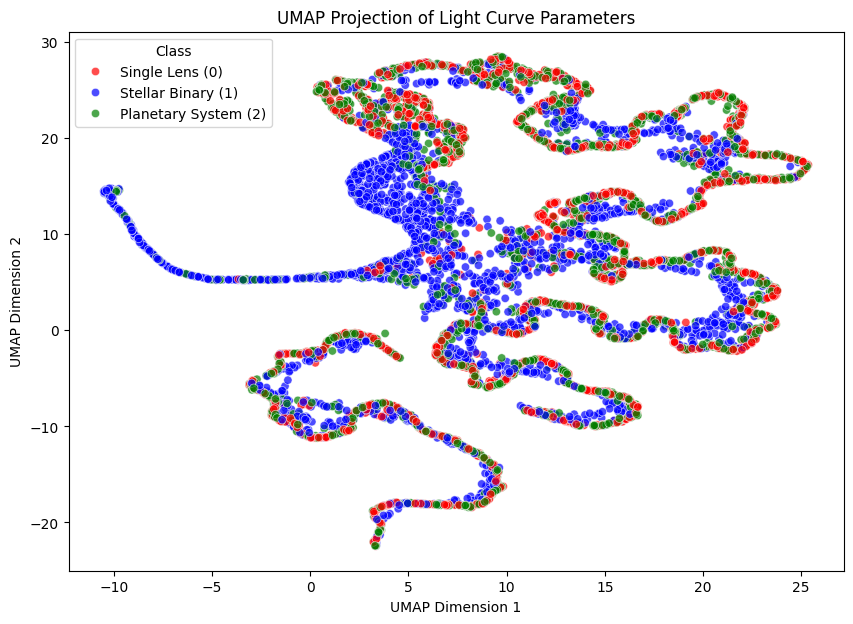

In [2]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/drive/MyDrive/Git_Repositories/Data/all_params_pspl_cheby.txt'

columns_to_keep = ['chi2', 'residual_mean', 'residual_median', 'residual_std', 'bin_mean', 'bin_median',
                   'bin_std', 'pos_log10_Cheby_cj_sqr_minus_one', 'Cheby_a2',  'Cheby_a4', 'Cheby_a6', 'Cheby_a8',
                   'Cheby_a10',  'delta_A_chebyshev_sqr', 'eta', 'gamma', 'class_label']

# Load the dataset while keeping only the specified columns
df = pd.read_csv(file_path, usecols=columns_to_keep, sep=',')

# Extract features (first 16 columns) and labels (last column)
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].astype(int)  # Convert class labels to integers

# Apply UMAP to reduce dimensions to 2D
umap_2d = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.5, metric='euclidean', random_state=42, spread=1.5)
X_umap_2d = umap_2d.fit_transform(X)

# Define colors for each class
color_map = {0: 'red', 1: 'blue', 2: 'green'}
unique_classes = np.unique(y)

# Create a scatter plot with correct colors
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x=X_umap_2d[:, 0], y=X_umap_2d[:, 1],
    hue=y, palette=[color_map[c] for c in unique_classes], alpha=0.7
)

# Manually adjust the legend to match the colors
handles, _ = scatter.get_legend_handles_labels()
plt.legend(handles, [f"Single Lens (0)", "Stellar Binary (1)", "Planetary System (2)"], title="Class")

# Customize labels and title
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Projection of Light Curve Parameters")
plt.show()


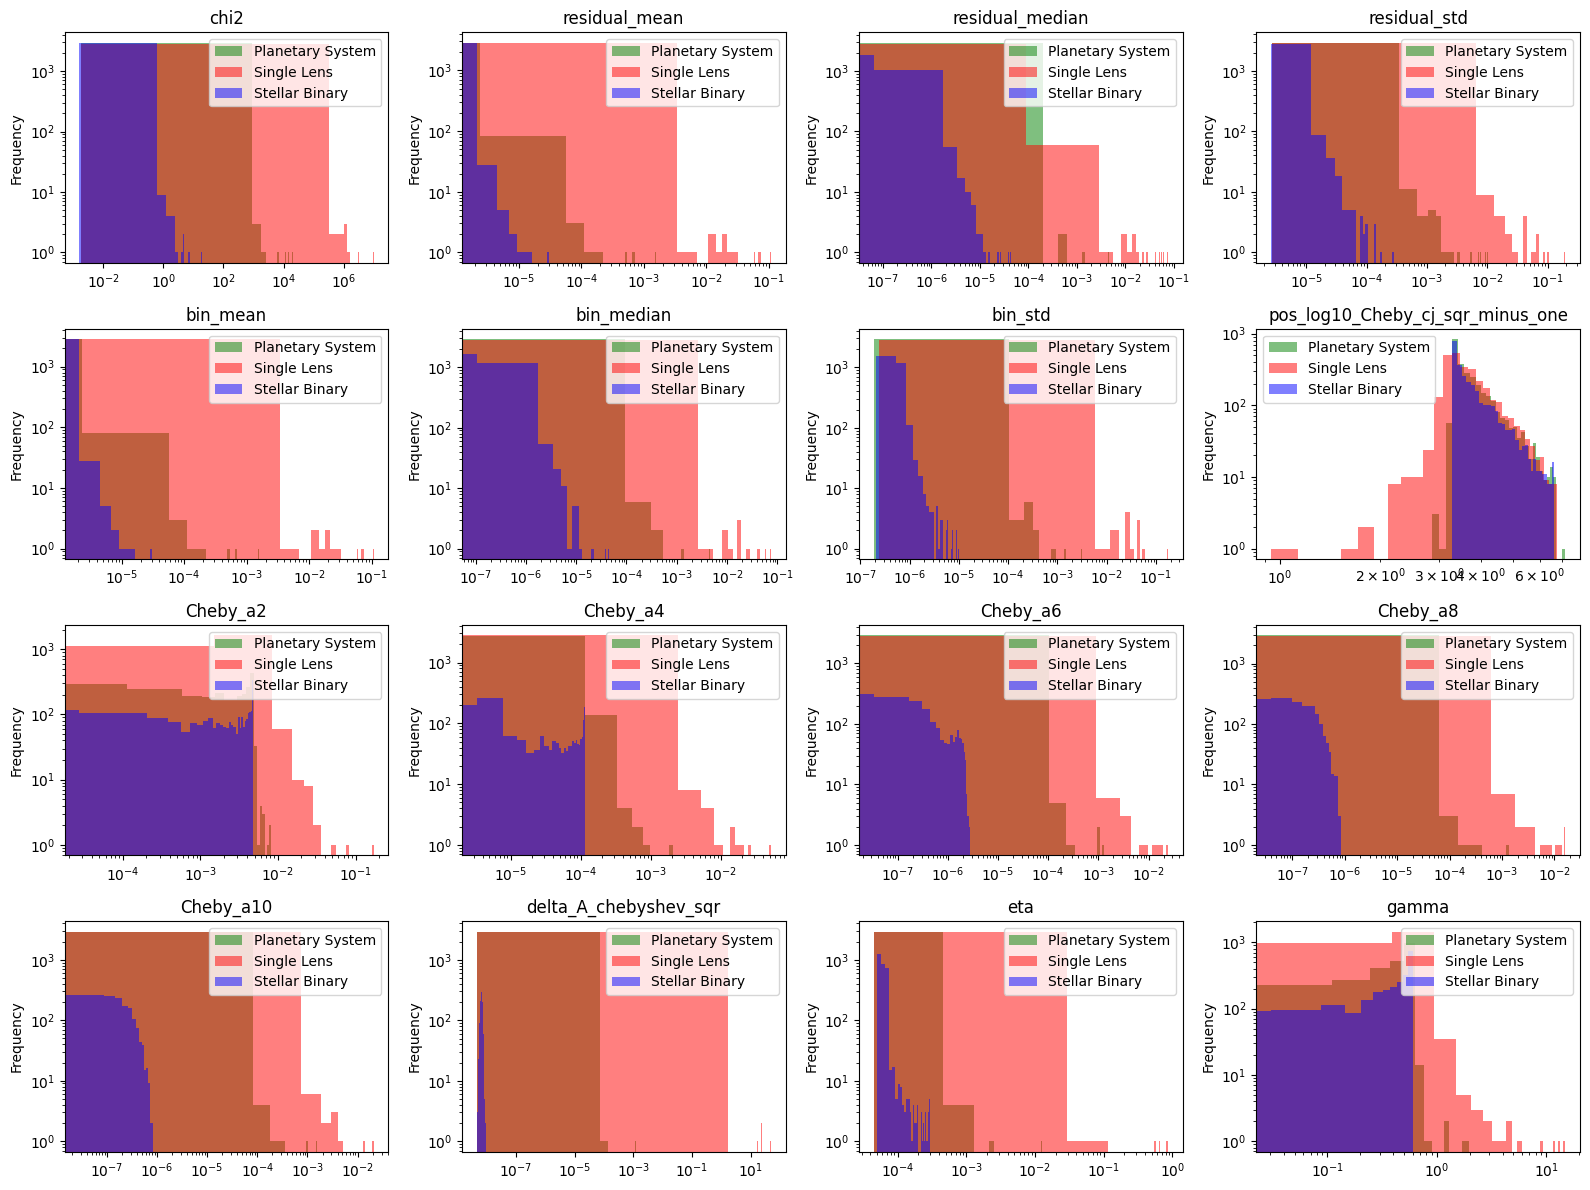

In [4]:
import matplotlib.pyplot as plt
import numpy as np






columns_to_keep = ['chi2', 'residual_mean', 'residual_median', 'residual_std', 'bin_mean', 'bin_median',
                   'bin_std', 'pos_log10_Cheby_cj_sqr_minus_one', 'Cheby_a2',  'Cheby_a4', 'Cheby_a6', 'Cheby_a8',
                   'Cheby_a10',  'delta_A_chebyshev_sqr', 'eta', 'gamma', ]





# Define the number of columns for subplots
n_cols = 4
n_rows = int(np.ceil(len(columns_to_keep) / n_cols))  # Compute required rows

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Define colors and proper legend labels for each class
colors = ['green', 'red', 'blue']
class_names = ["Planetary System", "Single Lens", "Stellar Binary"]
labels = [ 2, 1, 0]  # Class labels

# Plot histograms for each parameter
for i, column in enumerate(columns_to_keep):  # Exclude class_label
    ax = axes[i]

    # Plot histogram for each class label
    for j, label in enumerate(labels):
        data = df[df['class_label'] == label][column]
        ax.hist(data, bins=30, color=colors[j], alpha=0.5, label=class_names[j])

    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()


    # Hide empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


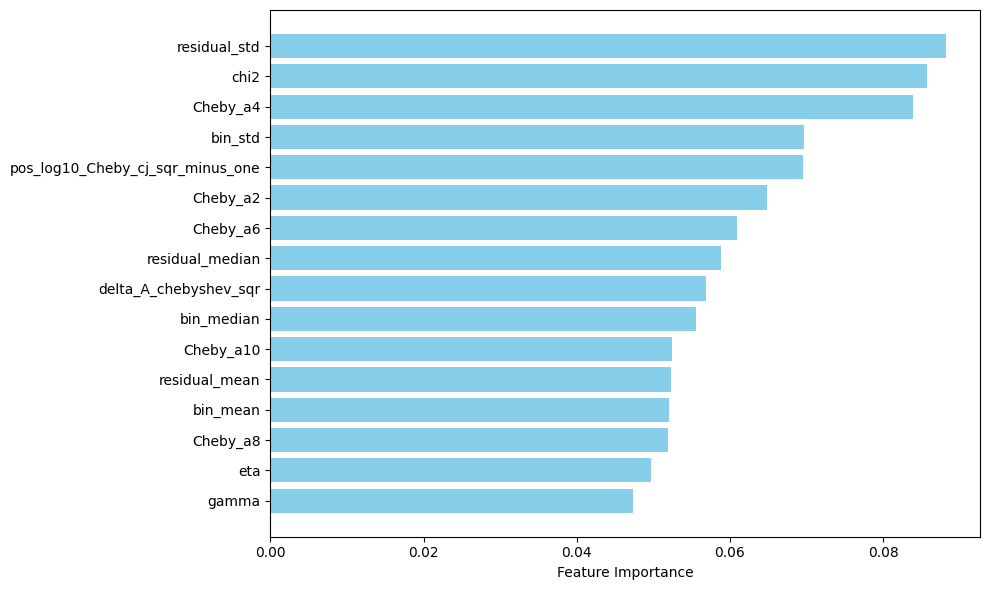

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/Git_Repositories/Data/all_params_pspl_cheby.txt'

columns_to_keep = ['chi2', 'residual_mean', 'residual_median', 'residual_std', 'bin_mean', 'bin_median',
                   'bin_std', 'pos_log10_Cheby_cj_sqr_minus_one', 'Cheby_a2',  'Cheby_a4', 'Cheby_a6', 'Cheby_a8',
                   'Cheby_a10',  'delta_A_chebyshev_sqr', 'eta', 'gamma', 'class_label']

df = pd.read_csv(file_path, usecols=columns_to_keep, sep=',')

# Split into features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict
y_pred = rf_classifier.predict(X_test)

# Feature importance
feature_importances = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_feature_names = [df.columns[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.gca().invert_yaxis()  # Makes the most important feature appear at the top
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()
